### Exponential Moving Avarage Model - Benchmark

TODO

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from utils import split_sequence, get_apple_close_price, plot_series
from utils import plot_residual_forecast_error, print_performance_metrics
from utils import get_range, difference, inverse_difference
from utils import train_test_split, NN_walk_forward_validation

In [79]:
apple_close_price = get_apple_close_price()

In [80]:
short_series = get_range(apple_close_price, '2003-01-01')

In [81]:
# Model parameters
look_back = 5 # days window look back
n_features = 1 # our only feature will be Close price 
n_outputs = 5 # days forecast

We need to first train/test split, then transform and scale our data

In [82]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [83]:
train, test= train_test_split(apple_close_price,'2018-05-31')

In [84]:
boxcox_series, lmbda = boxcox(train.values)

In [85]:
transformed_train = boxcox_series
transformed_test = boxcox(test, lmbda=lmbda)

# transformed_train = train.values
# transformed_test = test.values

In [86]:
from sklearn.preprocessing import MinMaxScaler

In [87]:
scaler = MinMaxScaler()

In [88]:
scaled_train = scaler.fit_transform(transformed_train.reshape(-1, 1))
scaled_test = scaler.transform(transformed_test.reshape(-1, 1))

In [89]:
X_train, y_train = split_sequence(scaled_train, look_back, n_outputs)
y_train = y_train.reshape(-1, n_outputs)

In [90]:
# see https://sciencing.com/calculate-exponential-moving-averages-8221813.html
def EMA_model(x_input, look_back, n_outputs, prev_ema, prev_day=None):
    if prev_day is None:
        prev_ema = np.mean(x_input) # EMA = SMA
    else:
        prev_ema = prev_day[-1] # EMA = previous EMA
    
    multiplier = 2/(look_back + 1)
    x_input = (x_input[-1] - prev_ema) * multiplier + prev_ema
    return np.repeat(x_input, n_outputs)

In [91]:
def MA_walk_forward_validation(train, test, 
                               size=1, 
                               look_back=1, n_outputs=1):
    
    past = train.reshape(-1,).copy()
    future = test.reshape(-1,)[:size]
    
    predictions = list()
    limit_range = len(future)
    
    prev_day = None

    for t in range(0, limit_range, n_outputs):
        x_input = past[-look_back:] # grab the last look_back days from the past
        x_input = x_input.reshape(-look_back,)
                
        # predict the next n_outputs days
        y_hat = EMA_model(x_input, look_back, n_outputs, prev_day)
        prev_day = y_hat
        
        predictions.append(y_hat)

        # add the new n_outputs days (real ones) to the past
        past = np.concatenate((past, future[t:t+n_outputs]))
            
    return np.array(predictions).reshape(-1,)[:len(future)]

In [92]:
size = 252 # approx. one year
predictions = MA_walk_forward_validation(scaled_train, 
                                         scaled_test[:252],
                                         size=size,
                                         look_back=look_back, 
                                         n_outputs=n_outputs)

In [93]:
from utils import plot_walk_forward_validation
from utils import plot_residual_forecast_error, print_performance_metrics

We need to revert the scaling and transformation:

In [94]:
descaled_preds = scaler.inverse_transform(predictions.reshape(-1, 1))
descaled_test = scaler.inverse_transform(scaled_test.reshape(-1, 1))

descaled_preds = inv_boxcox(descaled_preds, lmbda)
descaled_test = inv_boxcox(descaled_test, lmbda)

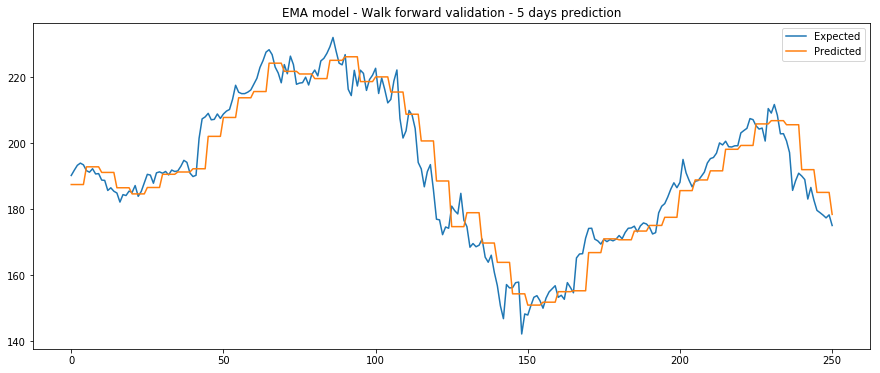

In [95]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.plot(descaled_test[:size])
plt.plot(descaled_preds)
ax.set_title('EMA model - Walk forward validation - {} days prediction'.format(n_outputs))
ax.legend(['Expected', 'Predicted'])

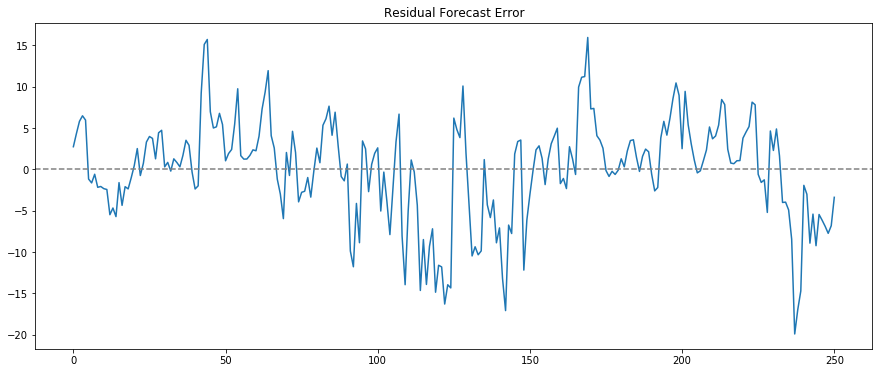

In [96]:
plot_residual_forecast_error(descaled_preds, descaled_test[:size])

In [97]:
print_performance_metrics(descaled_preds, 
                          descaled_test[:size],
                          model_name='EMA model', 
                          total_days=size, steps=n_outputs)

EMA model[252 days, 5 days forecast]:

Forecast Bias: -0.074
MAE: 4.694
MSE: 37.944
RMSE: 6.160
MAPE: 2.504
